# Model 3 — Churn Propensity: Training & Evaluation

This notebook trains, evaluates, and explains a **churn propensity model** for a telecommunications
customer base (Telco Customer Churn dataset).  

The pipeline follows these steps:

1. Load engineered customer features (`customer_features.parquet`)
2. Stratified 80/20 train/test split
3. Cross-validate three models: Naive baseline, Logistic Regression, LightGBM
4. Calibrate LightGBM probabilities with Isotonic Regression
5. Evaluate: ROC, PR curves, confusion matrix
6. Optimise decision threshold via a business cost function
7. Top-decile lift analysis
8. SHAP global feature importance
9. Persist model artifacts

---
**Cost model:**  
- False Negative (missed churner): **\$200** per customer  
- False Positive (unnecessary outreach): **\$20** per customer  

Churn prevalence ≈ 26.5%, so we weight positive examples with `scale_pos_weight = 2.77`.

## 1. Imports

In [1]:
from __future__ import annotations

import json
import os
import sys
import warnings
from datetime import datetime, timezone

os.environ.setdefault("LOKY_MAX_CPU_COUNT", "1")
os.environ.setdefault("MPLCONFIGDIR", "/tmp/mplconfig")
os.makedirs(os.environ["MPLCONFIGDIR"], exist_ok=True)
warnings.filterwarnings("ignore")

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    brier_score_loss,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import StratifiedKFold, train_test_split

# Add project root to path so src imports work
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
if BASE_DIR not in sys.path:
    sys.path.insert(0, BASE_DIR)

from src.feature_engineering import FEATURE_COLUMNS

print(f"Python: {sys.version.split()[0]}")
print(f"LightGBM: {lgb.__version__}")
print(f"SHAP: {shap.__version__}")
print(f"Feature columns ({len(FEATURE_COLUMNS)}): OK")

Python: 3.13.5
LightGBM: 4.6.0
SHAP: 0.50.0
Feature columns (32): OK


## 2. Load Features and Inspect Class Balance

Loaded: 7,043 rows x 35 columns

X shape: (7043, 32)
y shape: (7043,)

Class distribution:
  No Churn (0): 5,165  (73.3%)
  Churn    (1): 1,878  (26.7%)


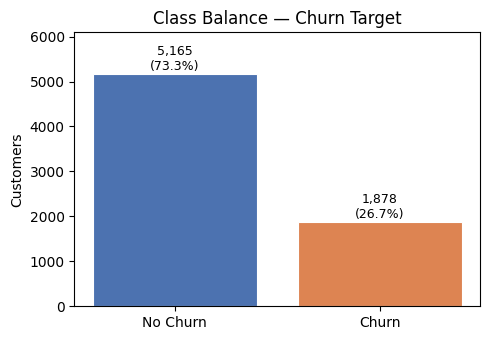

In [2]:
# ---------------------------------------------------------------------------
# Paths
# ---------------------------------------------------------------------------
CUSTOMER_FEATURES_PARQUET = os.path.join(BASE_DIR, "data", "processed", "customer_features.parquet")
MODELS_DIR = os.path.join(BASE_DIR, "models")
DOCS_DIR = os.path.join(BASE_DIR, "docs")

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(DOCS_DIR, exist_ok=True)

TARGET_COLUMN = "Churn"
CUSTOMER_ID_COLUMN = "customerID"

# ---------------------------------------------------------------------------
# Load
# ---------------------------------------------------------------------------
df = pd.read_parquet(CUSTOMER_FEATURES_PARQUET, engine="pyarrow")
print(f"Loaded: {df.shape[0]:,} rows x {df.shape[1]} columns")

X = df[FEATURE_COLUMNS].copy()
y = df[TARGET_COLUMN].astype(int).copy()
customer_ids = df[CUSTOMER_ID_COLUMN].copy()

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print()

# Class balance
class_counts = y.value_counts().sort_index()
print("Class distribution:")
print(f"  No Churn (0): {class_counts[0]:,}  ({class_counts[0]/len(y):.1%})")
print(f"  Churn    (1): {class_counts[1]:,}  ({class_counts[1]/len(y):.1%})")

fig, ax = plt.subplots(figsize=(5, 3.5))
bars = ax.bar(["No Churn", "Churn"], class_counts.values,
               color=["#4C72B0", "#DD8452"], edgecolor="white", linewidth=0.8)
for bar, count in zip(bars, class_counts.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 20,
            f"{count:,}\n({count/len(y):.1%})", ha="center", va="bottom", fontsize=9)
ax.set_title("Class Balance — Churn Target", fontsize=12)
ax.set_ylabel("Customers")
ax.set_ylim(0, class_counts.max() * 1.18)
plt.tight_layout()
plt.show()

## 3. Train/Test Split with Class Distribution Check

Train: 5,634 rows  |  Test: 1,409 rows
Train churn rate: 26.7%   Test churn rate: 26.7%


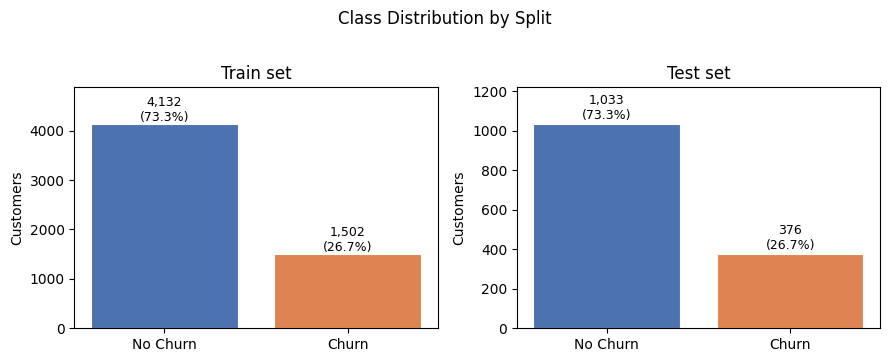

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, customer_ids,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE,
)

# Reset indices for clean iloc access later
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)
ids_train = ids_train.reset_index(drop=True)
ids_test  = ids_test.reset_index(drop=True)

print(f"Train: {len(X_train):,} rows  |  Test: {len(X_test):,} rows")
print(f"Train churn rate: {y_train.mean():.1%}   Test churn rate: {y_test.mean():.1%}")

# Side-by-side bar chart
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
for ax, y_split, title in zip(axes, [y_train, y_test], ["Train set", "Test set"]):
    counts = y_split.value_counts().sort_index()
    ax.bar(["No Churn", "Churn"], counts.values,
           color=["#4C72B0", "#DD8452"], edgecolor="white", linewidth=0.8)
    for i, (v, pct) in enumerate(zip(counts.values, counts.values / len(y_split))):
        ax.text(i, v + 10, f"{v:,}\n({pct:.1%})", ha="center", va="bottom", fontsize=9)
    ax.set_title(title)
    ax.set_ylabel("Customers")
    ax.set_ylim(0, counts.max() * 1.18)
plt.suptitle("Class Distribution by Split", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

## 4. Baseline Models and Cross-Validated AUC

In [4]:
N_FOLDS = 5
SCALE_POS_WEIGHT = 2.77  # 73.5 / 26.5

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

naive_prob = float(y_train.mean())

naive_cv, lr_cv, lgbm_cv = [], [], []

for fold_i, (tr_idx, vl_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_tr, X_vl = X_train.iloc[tr_idx], X_train.iloc[vl_idx]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[vl_idx]

    # Naive
    naive_cv.append(roc_auc_score(y_vl, np.full(len(y_vl), naive_prob)))

    # Logistic Regression
    lr_fold = LogisticRegression(C=1.0, max_iter=1000, random_state=RANDOM_STATE)
    lr_fold.fit(X_tr, y_tr)
    lr_cv.append(roc_auc_score(y_vl, lr_fold.predict_proba(X_vl)[:, 1]))

    # LightGBM
    lgbm_fold = lgb.LGBMClassifier(
        objective="binary", metric="auc",
        learning_rate=0.05, num_leaves=31,
        min_child_samples=20, feature_fraction=0.8,
        bagging_fraction=0.8, bagging_freq=5,
        scale_pos_weight=SCALE_POS_WEIGHT,
        n_estimators=300, random_state=RANDOM_STATE, verbose=-1,
    )
    lgbm_fold.fit(X_tr, y_tr)
    lgbm_cv.append(roc_auc_score(y_vl, lgbm_fold.predict_proba(X_vl)[:, 1]))

    print(f"  Fold {fold_i}: Naive={naive_cv[-1]:.4f}  LR={lr_cv[-1]:.4f}  LGBM={lgbm_cv[-1]:.4f}")

print()
cv_summary = pd.DataFrame({
    "Model": ["Naive Baseline", "Logistic Regression", "LightGBM"],
    "Mean CV AUC": [np.mean(naive_cv), np.mean(lr_cv), np.mean(lgbm_cv)],
    "Std CV AUC":  [np.std(naive_cv),  np.std(lr_cv),  np.std(lgbm_cv)],
})
cv_summary["Mean CV AUC"] = cv_summary["Mean CV AUC"].map("{:.4f}".format)
cv_summary["Std CV AUC"]  = cv_summary["Std CV AUC"].map("{:.4f}".format)
print(cv_summary.to_string(index=False))

  Fold 1: Naive=0.5000  LR=0.8292  LGBM=0.8132


  Fold 2: Naive=0.5000  LR=0.8214  LGBM=0.8098


  Fold 3: Naive=0.5000  LR=0.8002  LGBM=0.7707


  Fold 4: Naive=0.5000  LR=0.8217  LGBM=0.7792


  Fold 5: Naive=0.5000  LR=0.8200  LGBM=0.7901

              Model Mean CV AUC Std CV AUC
     Naive Baseline      0.5000     0.0000
Logistic Regression      0.8185     0.0097
           LightGBM      0.7926     0.0166


## 5. LightGBM Final Training

In [5]:
# ============================================================
# Hyperparameter configuration — edit here to experiment
# ============================================================
LGBM_PARAMS = dict(
    objective="binary",
    metric="auc",
    learning_rate=0.05,
    num_leaves=31,
    min_child_samples=20,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    scale_pos_weight=SCALE_POS_WEIGHT,
    n_estimators=300,
    random_state=RANDOM_STATE,
    verbose=-1,
)
# ============================================================

print("Training LightGBM on full training set...")
print(f"  Params: {LGBM_PARAMS}")

lgbm_model = lgb.LGBMClassifier(**LGBM_PARAMS)
lgbm_model.fit(X_train, y_train)

# Also train logistic regression final model
lr_model = LogisticRegression(C=1.0, max_iter=1000, random_state=RANDOM_STATE)
lr_model.fit(X_train, y_train)

print(f"  LightGBM trained: {lgbm_model.n_estimators_} trees")
print(f"  Logistic Regression trained: {X_train.shape[1]} features")

Training LightGBM on full training set...
  Params: {'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.05, 'num_leaves': 31, 'min_child_samples': 20, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'scale_pos_weight': 2.77, 'n_estimators': 300, 'random_state': 42, 'verbose': -1}


  LightGBM trained: 300 trees
  Logistic Regression trained: 32 features


## 6. Probability Calibration with Isotonic Regression

Calibration: fit=4,507 rows, cal=1,127 rows
Calibrator type: IsotonicRegression


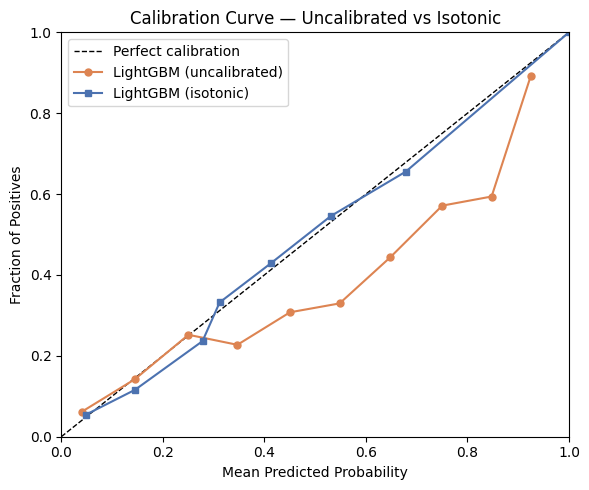

In [6]:
# Internal 80/20 split of training set for calibration
X_fit, X_cal, y_fit, y_cal = train_test_split(
    X_train, y_train,
    test_size=0.20,
    stratify=y_train,
    random_state=RANDOM_STATE,
)

# Refit LightGBM on 80% portion
lgbm_cal_inner = lgb.LGBMClassifier(**LGBM_PARAMS)
lgbm_cal_inner.fit(X_fit, y_fit)

# Score calibration hold-out
cal_raw = lgbm_cal_inner.predict_proba(X_cal)[:, 1]

# Fit isotonic regression
calibrator = IsotonicRegression(y_min=0.0, y_max=1.0, out_of_bounds="clip")
calibrator.fit(cal_raw, y_cal)

print(f"Calibration: fit={len(X_fit):,} rows, cal={len(X_cal):,} rows")
print(f"Calibrator type: {type(calibrator).__name__}")

# ---------------------------------------------------------------------------
# Plot: uncalibrated vs calibrated probability curves
# ---------------------------------------------------------------------------
from sklearn.calibration import calibration_curve

# Get test set scores from the FULL model (trained on all X_train)
test_raw_scores = lgbm_model.predict_proba(X_test)[:, 1]
test_cal_scores = calibrator.predict(test_raw_scores)

frac_pos_raw, mean_pred_raw = calibration_curve(y_test, test_raw_scores, n_bins=10)
frac_pos_cal, mean_pred_cal = calibration_curve(y_test, test_cal_scores, n_bins=10)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot([0, 1], [0, 1], "k--", linewidth=1, label="Perfect calibration")
ax.plot(mean_pred_raw, frac_pos_raw, "o-", color="#DD8452", label="LightGBM (uncalibrated)", markersize=5)
ax.plot(mean_pred_cal, frac_pos_cal, "s-", color="#4C72B0", label="LightGBM (isotonic)", markersize=5)
ax.set_xlabel("Mean Predicted Probability")
ax.set_ylabel("Fraction of Positives")
ax.set_title("Calibration Curve — Uncalibrated vs Isotonic")
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

## 7. Evaluation: ROC Curve, PR Curve, Confusion Matrix

AUC-ROC  — Naive: 0.5000 | LR: 0.8162 | LightGBM (cal): 0.7883
PR-AUC   — LightGBM: 0.5401
Brier    — LightGBM: 0.155158


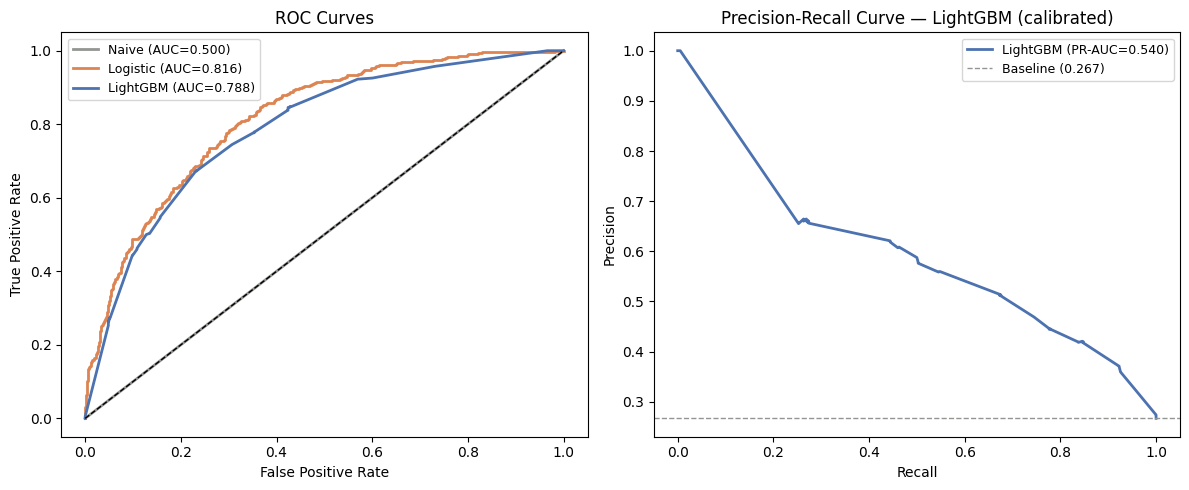


Metrics @ threshold 0.5:
  F1:        0.5234
  Precision: 0.6070
  Recall:    0.4601


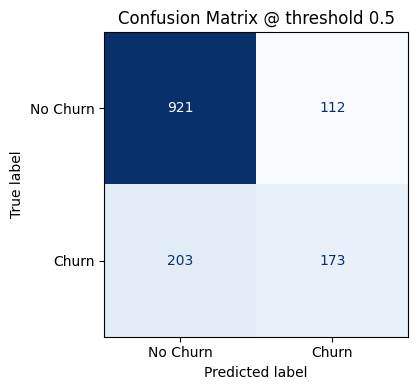

In [7]:
# Score all models on test set
naive_scores  = np.full(len(y_test), float(y_train.mean()))
lr_scores     = lr_model.predict_proba(X_test)[:, 1]
lgbm_raw      = lgbm_model.predict_proba(X_test)[:, 1]
lgbm_scores   = calibrator.predict(lgbm_raw)

auc_naive = roc_auc_score(y_test, naive_scores)
auc_lr    = roc_auc_score(y_test, lr_scores)
auc_lgbm  = roc_auc_score(y_test, lgbm_scores)

pr_auc_lgbm = average_precision_score(y_test, lgbm_scores)
brier_lgbm  = brier_score_loss(y_test, lgbm_scores)

print(f"AUC-ROC  — Naive: {auc_naive:.4f} | LR: {auc_lr:.4f} | LightGBM (cal): {auc_lgbm:.4f}")
print(f"PR-AUC   — LightGBM: {pr_auc_lgbm:.4f}")
print(f"Brier    — LightGBM: {brier_lgbm:.6f}")

# ---------------------------------------------------------------------------
# ROC Curve
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
for scores, label, color in [
    (naive_scores, f"Naive (AUC={auc_naive:.3f})",  "#929591"),
    (lr_scores,    f"Logistic (AUC={auc_lr:.3f})",   "#DD8452"),
    (lgbm_scores,  f"LightGBM (AUC={auc_lgbm:.3f})", "#4C72B0"),
]:
    fpr, tpr, _ = roc_curve(y_test, scores)
    ax.plot(fpr, tpr, label=label, linewidth=2, color=color)
ax.plot([0, 1], [0, 1], "k--", linewidth=1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves")
ax.legend(fontsize=9)

# ---------------------------------------------------------------------------
# PR Curve
# ---------------------------------------------------------------------------
ax = axes[1]
prec, rec, _ = precision_recall_curve(y_test, lgbm_scores)
ax.plot(rec, prec, color="#4C72B0", linewidth=2, label=f"LightGBM (PR-AUC={pr_auc_lgbm:.3f})")
ax.axhline(y_test.mean(), color="#929591", linestyle="--", linewidth=1, label=f"Baseline ({y_test.mean():.3f})")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve — LightGBM (calibrated)")
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Confusion Matrix at 0.5 threshold
# ---------------------------------------------------------------------------
y_pred_05 = (lgbm_scores >= 0.5).astype(int)
print(f"\nMetrics @ threshold 0.5:")
print(f"  F1:        {f1_score(y_test, y_pred_05):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_05):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_05):.4f}")

fig, ax = plt.subplots(figsize=(5, 4))
cm = confusion_matrix(y_test, y_pred_05)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Churn", "Churn"])
disp.plot(ax=ax, colorbar=False, cmap="Blues")
ax.set_title("Confusion Matrix @ threshold 0.5")
plt.tight_layout()
plt.show()

## 8. Threshold Optimisation: Cost Curve

Cost-optimal threshold: 0.16
Total cost at optimal:  $17,580
F1 at optimal:          0.5290
Precision:              0.3707
Recall:                 0.9229


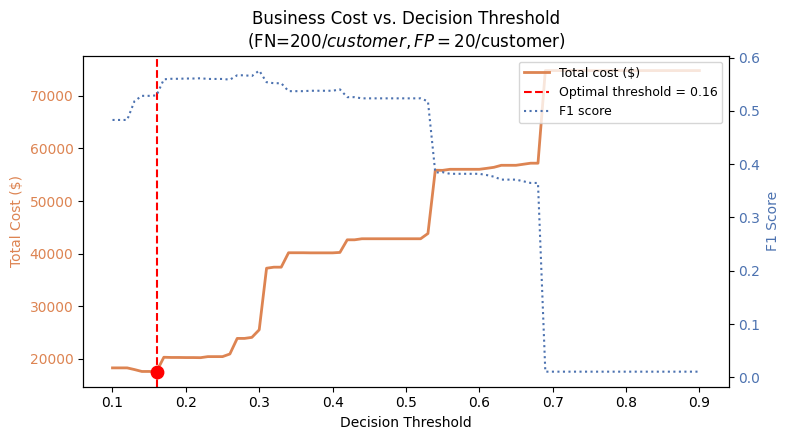

In [8]:
COST_FN = 200   # missed churner
COST_FP = 20    # false alarm

thresholds = np.linspace(0.1, 0.9, 81)
costs = []
f1s = []

for thr in thresholds:
    y_pred = (lgbm_scores >= thr).astype(int)
    cm_thr = confusion_matrix(y_test, y_pred)
    fn = cm_thr[1, 0] if cm_thr.shape == (2, 2) else 0
    fp = cm_thr[0, 1] if cm_thr.shape == (2, 2) else 0
    costs.append(fn * COST_FN + fp * COST_FP)
    f1s.append(f1_score(y_test, y_pred, zero_division=0))

costs = np.array(costs)
f1s   = np.array(f1s)

best_idx = int(np.argmin(costs))
cost_optimal_threshold = float(thresholds[best_idx])
cost_optimal_value     = float(costs[best_idx])

print(f"Cost-optimal threshold: {cost_optimal_threshold:.2f}")
print(f"Total cost at optimal:  ${cost_optimal_value:,.0f}")
print(f"F1 at optimal:          {f1s[best_idx]:.4f}")

# Metrics at optimal threshold
y_pred_opt = (lgbm_scores >= cost_optimal_threshold).astype(int)
print(f"Precision:              {precision_score(y_test, y_pred_opt):.4f}")
print(f"Recall:                 {recall_score(y_test, y_pred_opt):.4f}")

# ---------------------------------------------------------------------------
# Cost curve plot
# ---------------------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(8, 4.5))
ax2 = ax1.twinx()

ax1.plot(thresholds, costs, color="#DD8452", linewidth=2, label="Total cost ($)")
ax1.axvline(cost_optimal_threshold, color="red", linestyle="--", linewidth=1.5,
            label=f"Optimal threshold = {cost_optimal_threshold:.2f}")
ax1.scatter([cost_optimal_threshold], [cost_optimal_value], color="red", s=80, zorder=5)
ax1.set_xlabel("Decision Threshold")
ax1.set_ylabel("Total Cost ($)", color="#DD8452")
ax1.tick_params(axis="y", labelcolor="#DD8452")

ax2.plot(thresholds, f1s, color="#4C72B0", linewidth=1.5, linestyle=":", label="F1 score")
ax2.set_ylabel("F1 Score", color="#4C72B0")
ax2.tick_params(axis="y", labelcolor="#4C72B0")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=9, loc="upper right")

ax1.set_title(f"Business Cost vs. Decision Threshold\n"
              f"(FN=${COST_FN}/customer, FP=${COST_FP}/customer)")
plt.tight_layout()
plt.show()

## 9. Top-Decile Lift Chart

Top-decile lift table:
Decile   N Churn Rate Lift vs. Mean
    D1   2     100.0%         3.75x
    D2 268      61.6%         2.31x
    D3  98      39.8%         1.49x
    D4 129      37.2%         1.39x
    D5 162      24.1%         0.90x
    D6 106      24.5%         0.92x
    D7 203      14.3%         0.54x
    D8 147       8.2%         0.31x
    D9 294       5.4%         0.20x

Top-20% (threshold >= 0.524): 285 customers
  Capture rate : 46.0% of all churners
  Lift ratio   : 2.27x overall churn rate


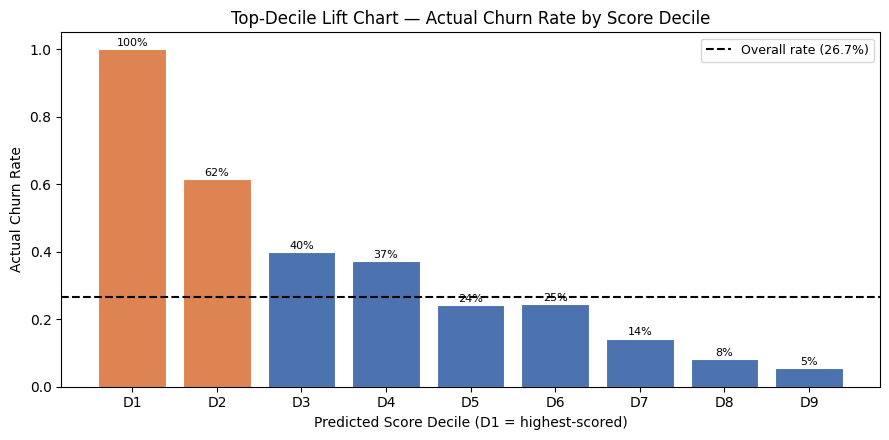

In [9]:
# Assign score deciles (1 = top-scored, 10 = lowest-scored)
# np.percentile-based cut avoids the unequal-bin problem from qcut+duplicates
score_series = pd.Series(lgbm_scores)
quantile_edges = [score_series.quantile(q) for q in [i/10 for i in range(11)]]

# If duplicate edges collapse bins, pd.cut with duplicates='drop' handles it
decile_labels_cat, bin_edges = pd.cut(
    score_series,
    bins=sorted(set(quantile_edges)),   # unique edges only
    labels=False,
    include_lowest=True,
    retbins=True,
)
n_bins = int(decile_labels_cat.max()) + 1
label_names = [f"D{i}" for i in range(1, n_bins + 1)]
decile_labels = pd.Categorical(
    [f"D{int(v)+1}" if not pd.isna(v) else None for v in decile_labels_cat],
    categories=label_names,
    ordered=True,
)
decile_df = pd.DataFrame({
    "decile": decile_labels,
    "churn": y_test.values,
    "score": lgbm_scores,
})

# Sort so D1 = highest-scored (most likely to churn)
decile_order = label_names
decile_stats = (
    decile_df.groupby("decile", observed=True)
    .agg(churn_rate=("churn", "mean"), n=("churn", "count"))
    .reindex(decile_order)
    .iloc[::-1]
    .reset_index()
)
decile_stats.index = [f"D{i}" for i in range(1, len(decile_stats) + 1)]

overall_churn_rate = float(y_test.mean())
lift = decile_stats["churn_rate"] / overall_churn_rate

print("Top-decile lift table:")
print(pd.DataFrame({
    "Decile": decile_stats.index,
    "N":      decile_stats["n"],
    "Churn Rate": decile_stats["churn_rate"].map("{:.1%}".format),
    "Lift vs. Mean": lift.map("{:.2f}x".format),
}).to_string(index=False))

# ---------------------------------------------------------------------------
# Top-20%: use the 80th-percentile threshold (actual 20% of customers)
# ---------------------------------------------------------------------------
pct80 = float(np.percentile(lgbm_scores, 80))
top20_mask = lgbm_scores >= pct80
top20_churn_rate  = float(y_test.values[top20_mask].mean())
top20_capture     = float(y_test.values[top20_mask].sum() / y_test.sum())
top20_lift_ratio  = top20_churn_rate / overall_churn_rate

print()
print(f"Top-20% (threshold >= {pct80:.3f}): {top20_mask.sum()} customers")
print(f"  Capture rate : {top20_capture:.1%} of all churners")
print(f"  Lift ratio   : {top20_lift_ratio:.2f}x overall churn rate")

fig, ax = plt.subplots(figsize=(9, 4.5))
bars = ax.bar(
    decile_stats.index,
    decile_stats["churn_rate"],
    color=["#DD8452" if r >= overall_churn_rate * 1.5 else "#4C72B0"
           for r in decile_stats["churn_rate"]],
    edgecolor="white", linewidth=0.8,
)
ax.axhline(overall_churn_rate, color="black", linestyle="--", linewidth=1.5,
           label=f"Overall rate ({overall_churn_rate:.1%})")
for bar, rate in zip(bars, decile_stats["churn_rate"]):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.003,
            f"{rate:.0%}", ha="center", va="bottom", fontsize=8)
ax.set_xlabel("Predicted Score Decile (D1 = highest-scored)")
ax.set_ylabel("Actual Churn Rate")
ax.set_title("Top-Decile Lift Chart — Actual Churn Rate by Score Decile")
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()


## 10. SHAP Feature Importance

Computing SHAP values on test set...


SHAP values shape: (1409, 32)

Beeswarm plot (global feature impact):


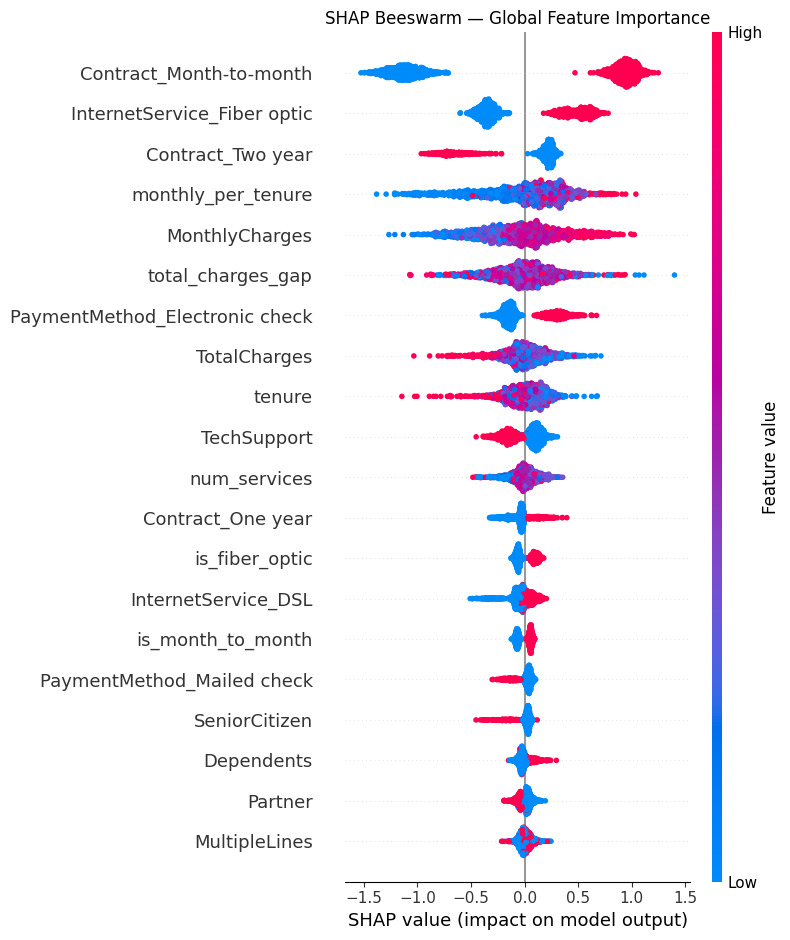

In [10]:
print("Computing SHAP values on test set...")
# Use TreeExplainer without background data to avoid additivity check failures
explainer = shap.TreeExplainer(lgbm_model)

# check_additivity=False suppresses the numerical-precision error from
# the interventional-perturbation background mismatch
shap_values = explainer.shap_values(X_test, check_additivity=False)

print(f"SHAP values shape: {repr(shap_values.shape if hasattr(shap_values, 'shape') else [s.shape for s in shap_values])}")

# ---------------------------------------------------------------------------
# Global beeswarm plot
# ---------------------------------------------------------------------------
print("\nBeeswarm plot (global feature impact):")
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="dot",
    max_display=20,
    show=False,  # keep figure open so plt.title/tight_layout work
)
plt.title("SHAP Beeswarm — Global Feature Importance")
plt.tight_layout()
plt.show()


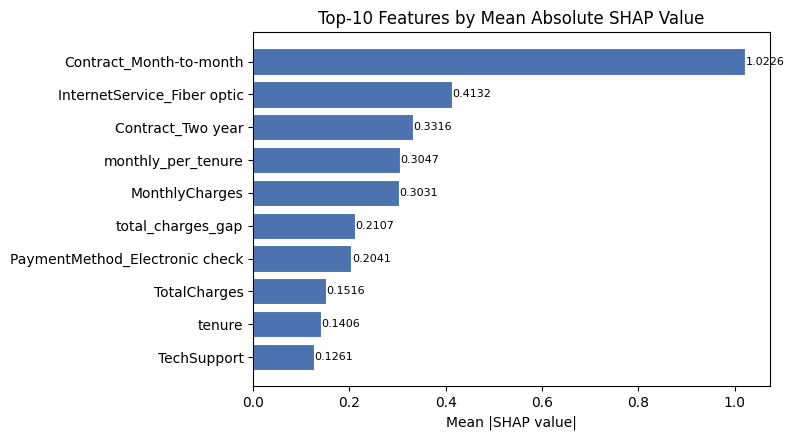

Top-10 features by mean |SHAP|:
Contract_Month-to-month           1.0226
InternetService_Fiber optic       0.4132
Contract_Two year                 0.3316
monthly_per_tenure                0.3047
MonthlyCharges                    0.3031
total_charges_gap                 0.2107
PaymentMethod_Electronic check    0.2041
TotalCharges                      0.1516
tenure                            0.1406
TechSupport                       0.1261


In [11]:
# ---------------------------------------------------------------------------
# Top-10 feature importance bar chart (mean |SHAP|)
# ---------------------------------------------------------------------------
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance = pd.Series(mean_abs_shap, index=FEATURE_COLUMNS).sort_values(ascending=False)

top10 = feature_importance.head(10)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.barh(top10.index[::-1], top10.values[::-1], color="#4C72B0", edgecolor="white", linewidth=0.8)
ax.set_xlabel("Mean |SHAP value|")
ax.set_title("Top-10 Features by Mean Absolute SHAP Value")
for i, (val, name) in enumerate(zip(top10.values[::-1], top10.index[::-1])):
    ax.text(val + 0.001, i, f"{val:.4f}", va="center", fontsize=8)
plt.tight_layout()
plt.show()

print("Top-10 features by mean |SHAP|:")
print(top10.map("{:.4f}".format).to_string())

## 11. Save Artifacts

In [12]:
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(DOCS_DIR, exist_ok=True)

MODEL_ARTIFACT     = os.path.join(MODELS_DIR, "lgbm_churn.pkl")
CALIBRATOR_ARTIFACT = os.path.join(MODELS_DIR, "probability_calibrator.pkl")
SHAP_ARTIFACT      = os.path.join(MODELS_DIR, "shap_explainer.pkl")
METADATA_PATH      = os.path.join(MODELS_DIR, "metadata.json")

# Save LightGBM model
joblib.dump(lgbm_model, MODEL_ARTIFACT)
print(f"Saved: {MODEL_ARTIFACT}")

# Save calibrator
joblib.dump(calibrator, CALIBRATOR_ARTIFACT)
print(f"Saved: {CALIBRATOR_ARTIFACT}")

# Save SHAP explainer
joblib.dump(explainer, SHAP_ARTIFACT)
print(f"Saved: {SHAP_ARTIFACT}")

# Save metadata.json
metadata = {
    "feature_columns": FEATURE_COLUMNS,
    "train_rows": int(len(X_train)),
    "test_rows": int(len(X_test)),
    "metrics": {
        "auc_naive":   float(auc_naive),
        "auc_lr":      float(auc_lr),
        "auc_lgbm":    float(auc_lgbm),
        "pr_auc_lgbm": float(pr_auc_lgbm),
        "brier_lgbm":  float(brier_lgbm),
        "f1_05":       float(f1_score(y_test, (lgbm_scores >= 0.5).astype(int))),
        "precision_05": float(precision_score(y_test, (lgbm_scores >= 0.5).astype(int))),
        "recall_05":   float(recall_score(y_test, (lgbm_scores >= 0.5).astype(int))),
        "top20_lift":         float(top20_lift_ratio),   # lift multiplier
        "top20_capture_rate": float(top20_capture),      # fraction of churners captured
    },
    "cost_optimal_threshold": float(cost_optimal_threshold),
    "timestamp": datetime.now(timezone.utc).isoformat(),
}
with open(METADATA_PATH, "w", encoding="utf-8") as fh:
    json.dump(metadata, fh, indent=2)
print(f"Saved: {METADATA_PATH}")

print("\n--- Metadata summary ---")
print(json.dumps({k: v for k, v in metadata.items() if k != "feature_columns"}, indent=2))

Saved: /Users/aayan/MarketingAnalytics/m03_churn/models/lgbm_churn.pkl
Saved: /Users/aayan/MarketingAnalytics/m03_churn/models/probability_calibrator.pkl
Saved: /Users/aayan/MarketingAnalytics/m03_churn/models/shap_explainer.pkl
Saved: /Users/aayan/MarketingAnalytics/m03_churn/models/metadata.json

--- Metadata summary ---
{
  "train_rows": 5634,
  "test_rows": 1409,
  "metrics": {
    "auc_naive": 0.5,
    "auc_lr": 0.8161726843937303,
    "auc_lgbm": 0.788258738234022,
    "pr_auc_lgbm": 0.540068204217915,
    "brier_lgbm": 0.15515846488372115,
    "f1_05": 0.5234493192133132,
    "precision_05": 0.6070175438596491,
    "recall_05": 0.4601063829787234,
    "top20_lift": 2.2747013811123553,
    "top20_capture_rate": 0.4601063829787234
  },
  "cost_optimal_threshold": 0.16,
  "timestamp": "2026-02-26T04:51:53.237897+00:00"
}
